In [144]:
import neat
import visualize

import os
import multiprocessing

import random

import pickle
import gzip

from time import time

In [145]:
class CustomReporter(neat.reporting.BaseReporter):
    
    def __init__(self, save_at, save_name = "custom_save"):
        self.start_time = 0
        self.generation = 0
        self.save_at = save_at
        self.save_name = save_name
    
    def start_generation(self, generation):
        print(f'\nStart Generation {generation}')
        self.start_time = time()
        self.generation = generation
    
    def end_generation(self, config, population, species_set):
        print(f'{len(population)} members in {len(species_set.species)} species')
        print(f'Finished, time: {round(time()-self.start_time, 3)} sec')
        
        if self.generation == self.save_at-1:
            print("save")
            with gzip.open(self.save_name, 'w', compresslevel=5) as f:
                data = (self.generation, config, population, species_set, random.getstate())
                pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    def post_evaluate(self, config, population, species, best_genome):
        print(f'Best Fitness: {best_genome.fitness}')

In [146]:
amount_of_tests = 20

def eval_genomes(genomes, config):
    random_boards = [[0]*16, [1]*16]
    answers = [[1]*16, [0]*16]
    
    for i in range(amount_of_tests-2):
        zero_count = random.randint(0,16)
        board = [0]*zero_count + [1]*(16-zero_count)
        random.shuffle(board)
        random_boards.append(board)
        
        answer = [{0:1, 1:0}[value] for value in board]
        answers.append(answer)
    
    for genome_id, genome in genomes:
        genome.fitness = 16.0*amount_of_tests
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for inp, outp in zip(random_boards, answers):
            result = net.activate(inp)
            genome.fitness -= sum([(result[i] - outp[i]) ** 2 for i in range(16)])

In [147]:
def run(config_file, generations = 300, pe = False):
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    config.fitness_threshold = (16*amount_of_tests)*0.9

    p = neat.Population(config)
    p.add_reporter(CustomReporter(generations))

    if pe:
        pe = neat.ParallelEvaluator(multiprocessing.cpu_count(), eval_genome)
        winner = p.run(pe.evaluate, generations)
    else:
        winner = p.run(eval_genomes, generations)

    print('\nWinner fitness:\n{!s}'.format(winner.fitness))
    
    node_names = {}
    for i in range(1, 17):
        node_names[-i] = f"input {i}"
        node_names[i-1] = f"output {i}"
    
    visualize.draw_net(config, winner, True, node_names=node_names, prune_unused=True)

    return winner

In [148]:
winner = run("config-feedforward", 2000)


Start Generation 0


KeyError: -1

In [161]:
def z_to_1(z):
    if z < 0.0:
        return 0.0
    elif z > 1.0:
        return 1.0
    else:
        return z

start_config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         "starting_config")

start_config.genome_config.add_activation('zero_to_one', z_to_1)

In [175]:
def create_correct_genome(size):
    squares = (size[0]*size[1])**2
    genome = neat.DefaultGenome(0)
    
    genome.nodes = {}
    for i in range(squares):
        node = neat.genes.DefaultNodeGene(i)
        node.bias = 1.0
        node.response = 1.0
        node.activation = "zero_to_one"
        node.aggregation = "sum"
        genome.nodes[i] = node
    
    genome.connections = {}
    for i in range(squares):
        gene = neat.genes.DefaultConnectionGene((-(i+1),i))
        gene.weight = -1.0
        gene.enabled = True
        genome.connections[(-(i+1),i)] = gene
    
    return genome

sizes = [(2,2), (2,3), (3,3), (3,4), (4,4)]
for size in sizes:
    size_genome = create_correct_genome(size)
    
    with gzip.open(f'correct_genomes/correct_genome-{str(size)}', 'w', compresslevel=5) as f:
        pickle.dump(size_genome, f, protocol=pickle.HIGHEST_PROTOCOL)

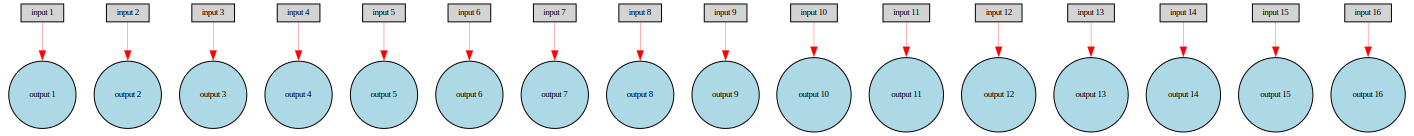

In [176]:
size_genome = create_correct_genome((2,2))

node_names = {}
for i in range(1, 17):
    node_names[-i] = f"input {i}"
    node_names[i-1] = f"output {i}"
    
visualize.draw_net(start_config, size_genome, True, node_names=node_names, prune_unused=True)

In [178]:
print(size_genome)

Key: 0
Fitness: None
Nodes:
	0 DefaultNodeGene(key=0, bias=1.0, response=1.0, activation=zero_to_one, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=1.0, response=1.0, activation=zero_to_one, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=1.0, response=1.0, activation=zero_to_one, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=1.0, response=1.0, activation=zero_to_one, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=1.0, response=1.0, activation=zero_to_one, aggregation=sum)
	5 DefaultNodeGene(key=5, bias=1.0, response=1.0, activation=zero_to_one, aggregation=sum)
	6 DefaultNodeGene(key=6, bias=1.0, response=1.0, activation=zero_to_one, aggregation=sum)
	7 DefaultNodeGene(key=7, bias=1.0, response=1.0, activation=zero_to_one, aggregation=sum)
	8 DefaultNodeGene(key=8, bias=1.0, response=1.0, activation=zero_to_one, aggregation=sum)
	9 DefaultNodeGene(key=9, bias=1.0, response=1.0, activation=zero_to_one, aggregation=sum)
	10 DefaultNodeGene(key=10, bias=1.0, response=1.0, activation